# Non Periodic Issues

The goal of this jupyter notebook is to find a good example of what I think is occuring. 

i.e. When we break grants a lot then we keep being pushed into selecting the same resource as others select which is a bad thing.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import t
import multiprocessing
import natsort


from matplotlib.ticker import FormatStrFormatter

In [2]:
import json
import os
import math
import random
import re

In [3]:
# JSON file containing the results for this simulation run
results_file = "/Users/brianmccarthy/git_repos/results-analysis/configs/cv2x.json"

In [4]:
figure_folder = "../data/figures/"

In [5]:
with open(results_file) as results_json:
    config = json.load(results_json)

In [6]:
# Markers to use for this run
markers = [".", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h",
           "H", "+", "x", "X", "D", "d", "|", "_", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## New results generation

In [7]:
def prepare_results(results, now):

    num_processes = 5
    if num_processes > multiprocessing.cpu_count():
        print("Too many processes, going to revert to total - 1")
        num_processes = multiprocessing.cpu_count() - 1

    processed_results = []
    for folder in results:
        config_name = folder.split("/")[-1]
        print("Results for config: {}".format(config_name))
        folder_results = []
        files = natsort.natsorted(os.listdir(folder))

        for i in range(len(files)):
            files[i] = "{}/{}".format(folder, files[i])

        i = 0
        while i < len(files):
            if len(files) < num_processes:
                num_processes = len(files)
            pool = multiprocessing.Pool(processes=num_processes)

            folder_results.append(pool.starmap(generate_results, zip(files[i: i+num_processes])))

            pool.close()
            pool.join()

            i += num_processes

        folder_results = [y for x in folder_results for y in x]
        # Go through each of the available stats and write them out to a csv file.
        output_csv_dir = "{}/data/processed_data/{}/{}-{}".format(os.getcwd(), "cv2x",
                                                                  config_name, now)
        os.makedirs(output_csv_dir, exist_ok=True)

        # Shortcut ensures we get the stats from the parsed results
        for stat in folder_results[0]:
            if "SCI" in stat:
                across_run_results(folder_results, stat, output_csv_dir, "txRxDistanceSCI")
            elif stat == "CBR":
                across_run_results(folder_results, stat, output_csv_dir, "Time")
            else:
                across_run_results(folder_results, stat, output_csv_dir, "txRxDistanceTB")

        processed_results.append(output_csv_dir)
    return processed_results

In [8]:
def generate_results(output_csv):

    results = {}

    pdr_sci_agg = pd.DataFrame()
    pdr_tb_agg = pd.DataFrame()
    ipg_agg = pd.DataFrame()
    cbr_agg = pd.DataFrame()

    for chunk in pd.read_csv(output_csv, chunksize=10 ** 6):

        # SCI PDR calculation
        pdr_sci_agg = stat_distance(pdr_sci_agg, chunk, "sciDecoded", "txRxDistanceSCI", True)

        # TB PDR calculation
        pdr_tb_agg = stat_distance(pdr_tb_agg, chunk, "tbDecoded", "txRxDistanceTB", True)

        # IPG calculation
        ipg_agg = stat_distance(ipg_agg, chunk, "interPacketDelay", "txRxDistanceTB", False)

        # CBR calculation doesn't aggregate the same way as the above so dealt with separately
        cbr_df = chunk[chunk["cbr"].notnull()]
        cbr_df = cbr_df[["Time", "cbr"]]
        cbr_df = cbr_df.groupby("Time").agg({"cbr": [np.mean, np.std, "count"]})
        cbr_df.columns = cbr_df.columns.droplevel()
        cbr_df = cbr_df.apply(lambda x: x * 100, axis=1)

        if cbr_agg.empty:
            cbr_agg = cbr_df
        else:
            # combine_chunks
            cbr_agg = cbr_agg.append(cbr_df)

    results["PDR-SCI"] = pdr_sci_agg
    results["PDR-TB"] = pdr_tb_agg
    results["IPG"] = ipg_agg
    results["CBR"] = cbr_agg

    return results

In [9]:
def stat_distance(agg_df, df, stat, distance, percentage):

    # Reduce the size of the DF to what we're interested in.
    distance_df = df[df[stat].notnull()]
    distance_df = distance_df[["Time", "NodeID", stat, distance]]
    distance_df = distance_df[distance_df[stat] > -1]

    max_distance = distance_df[distance].max()

    # Get the mean, std, count for each distance
    distance_df = distance_df.groupby(
        pd.cut(distance_df[distance], np.arange(0, max_distance, 10))).agg(
        {stat: [np.mean, "count"]})

    # Remove over head column
    distance_df.columns = distance_df.columns.droplevel()
    
    if percentage:
        distance_df = distance_df.apply(lambda x: x * 100, axis=1)

    if agg_df.empty:
        agg_df = distance_df
    else:
        # combine_chunks
        agg_df = pd.merge(agg_df, distance_df, on=distance, how='outer')
        agg_df = agg_df.apply(combine_line, axis=1, result_type='expand')
        agg_df = agg_df.rename({0: "mean", 1: "count"}, axis='columns')
    
    return agg_df

In [10]:
def combine_line(line):
    mean_a = line["mean_x"]
#     std_a = line["std_x"]
    count_a = line["count_x"]

    mean_b = line["mean_y"]
#     std_b = line["std_y"]
    count_b = line["count_y"]
    
    if np.isnan(mean_a) and np.isnan(mean_b):
        return [mean_a, count_a]
    elif np.isnan(mean_a) and not np.isnan(mean_b):
        return [mean_b, count_b]
    elif np.isnan(mean_b) and not np.isnan(mean_a):
        return [mean_a, count_a]
    else:
        ex_a = mean_a * count_a
        ex_b = mean_b * count_b
#         ex_squared_a = ((std_a ** 2) * (count_a - 1)) + ((ex_a ** 2) / count_a)
#         ex_squared_b = ((std_b ** 2) * (count_b - 1)) + ((ex_b ** 2) / count_b)

        tx = ex_a + ex_b
#         txx = ex_squared_a + ex_squared_b
        tn = count_a + count_b

        overall_mean = tx / tn
#         overall_std = math.sqrt((((txx - tx) ** 2) / tn) / (tn - 1))
        overall_count = tn

        return [overall_mean, overall_count]

In [11]:
def across_run_results(results, stat, output_csv_dir, merge_col):

    df = pd.DataFrame()
    for i in range(len(results)):
        if df.empty:
            df = results[i][stat]
        else:
            df = pd.merge(df, results[i][stat], how='outer', on=merge_col,
                          suffixes=(i, i + 1), copy=True, indicator=False)

    mean_cols = df.filter(regex='mean').columns

    n = len(mean_cols) - 1
    t_value = t.ppf(.95, n)

    df = df.apply(combine_runs, axis=1, result_type='expand', args=(mean_cols, t_value,))
    df = df.rename({0: "Mean", 1: "Confidence-Interval"}, axis='columns')
    df.to_csv("{}/{}.csv".format(output_csv_dir, stat))

In [12]:
def combine_runs(line, mean_cols, t_value):
    means = []
    for mean in mean_cols:
        if np.isnan(line[mean]):
            print("Mean was nan")
            means.append(0)
        else:
            means.append(line[mean])

    n = len(means)

    # Average Across runs
    xBar = sum(means) / n

    # Deviation between runs and average
    deviation = []
    for mean in means:
        deviation.append((mean - xBar) ** 2)
    s2 = sum(deviation) / (n - 1)

    # Confidence interval
    ci = t_value * math.sqrt(s2 / n)

    return [xBar, ci]

In [13]:
def pdr_graph(folders, graph, comparison, configurations):
    pdrs = []
    cis = []
    distances = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/{}.csv".format(folder, graph))
        pdrs.append(list(df["Mean"]))
        cis.append(list(df["Confidence-Interval"]))
        distances = (list(range(0, df.shape[0] * 10, 10)))
        
    pdr_dist(pdrs, distances, configurations, "{}-{}".format(graph, comparison), confidence_intervals=cis)

In [14]:
def ipg_graph(folders, graph, comparison, configurations):
    ipgs = []
    cis = []
    distances = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/{}.csv".format(folder, graph))
        ipgs.append(list(df["Mean"]))
        cis.append(list(df["Confidence-Interval"]))
        distances = (list(range(0, df.shape[0] * 10, 10)))
        
    ipg_dist(ipgs, distances, configurations, "{}-{}".format(graph, comparison), confidence_intervals=cis)

In [15]:
def cbr_graph(folders, comparison, graph, configurations):
    times = []
    cbr = []
    cis = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/CBR.csv".format(folder))
        times.append(list(df["Time"]))
        cbr.append(list(df["Mean"]))
#         cis.append(list(df["Confidence-Interval"]))
        
    cbr_plot(cbr, times, "{}-{}".format(graph, comparison), configurations, confidence_intervals=cis)

In [16]:
results_folders = [
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/After-5-high-density",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/DCC-Enabled",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/NO-CC",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/After-1",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/After-1-high-density",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/NO-CC-high-density",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Highway-fast",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/After-5",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Random-Access-Medium-Density",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Random-Access-Packet-Dropping-Medium-Density",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/RRI-Adaptation-CR-limit-MD",
    "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/RRI-Adaptation-DCC-MD"
]

processed_results = prepare_results(results_folders, "12:00:00")

Results for config: After-5-high-density


FileNotFoundError: [Errno 2] No such file or directory: '/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/After-5-high-density'

In [17]:
for comparison in config["cv2x"]["results"]["compare"]:
#     print(comparison)
    folders_for_comparison = []
    configurations = []
    for configuration in config["cv2x"]["results"]["compare"][comparison]:
        for folder in folders:
            if configuration in folder:
                folders_for_comparison.append(folder)
                configurations.append(configuration)
                
#     print("Folders for comparison: {}".format(folders_for_comparison))
    for graph in config["cv2x"]["results"]["graphs"]:
#         print("Comparison: {} Graph: {}".format(comparison, graph))
        if graph == "PDR-SCI":
            pdr_graph(folders_for_comparison, graph, comparison, configurations)
        elif graph == "PDR-TB":
            pdr_graph(folders_for_comparison, graph, comparison, configurations)
        elif graph == "IPG":
            ipg_graph(folders_for_comparison, graph, comparison, configurations)
        elif graph == "CBR":
            cbr_graph(folders_for_comparison, graph, comparison, configurations)

KeyError: 'compare'

## Random selection

In [18]:
def random_selection(raw_data_folder):    
    files = os.listdir(raw_data_folder)
    count = 0
    file = ""
    while ".csv" not in file and count < len(files) * 10:
        file = random.choice(files)
        count += 1

    result_file = raw_data_folder + "/" + file
    print("Random result file selected: {} in {} selections".format(result_file, count))
    random_df = pd.read_csv(result_file)

    # Reduce to the time we want which is from 502 onwards.
    random_df = random_df[random_df["Time"] >= 502]

    node = np.random.choice(random_df["NodeID"].unique(), 1)[0]
#     print("Node: {}".format(node))
    
    return random_df, node

## CBR individual

In [19]:
def plot_cbr(dfs, labels, plot_name):

    fig, ax = plt.subplots()

    for i in range(len(dfs)):
        df = dfs[i]
        ax.plot(df["Time"], df["cbr"], label=labels[i])

    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.legend(loc='lower left')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=0.1))

    ax.set_xlim([min(df["Time"]), (max(df["Time"]))])
    plt.xticks(np.arange(min(df["Time"]), (max(df["Time"]) + 1), step=1))

    plt.savefig("{}/{}.png".format(figure_folder, plot_name), dpi=300)

In [20]:
folder_path = "/Users/brianmccarthy/git_repos/results-analysis/data/raw_data/cv2x/"
interested_folders = ["NO-CC", "DCC-Enabled", "After-1", "After-5", "Highway-fast", "NO-CC-high-density", "After-1-high-density", "After-5-high-density"]
dfs = {}
selected_node = False
for folder in os.listdir(folder_path):
    if folder in interested_folders:
        result_path = folder_path + folder
        random_df, node = random_selection(result_path)
        if not selected_node:
            selected_node = node
            print("Selected Node: {}".format(selected_node))
        random_df = random_df[(random_df["NodeID"] == selected_node) & (random_df["cbr"].notnull())]
        dfs[folder] = random_df[["Time", "cbr"]]
        

FileNotFoundError: [Errno 2] No such file or directory: '/Users/brianmccarthy/git_repos/results-analysis/data/raw_data/cv2x/'

In [21]:
motivational_cbr = []
motivational_cbr.append(dfs["Highway-fast"])
motivational_cbr.append(dfs["NO-CC"])
motivational_cbr.append(dfs["NO-CC-high-density"])

cbr_medium = []
cbr_medium.append(dfs["DCC-Enabled"])
cbr_medium.append(dfs["NO-CC"])
cbr_medium.append(dfs["After-1"])
cbr_medium.append(dfs["After-5"])

cbr_high = []
cbr_high.append(dfs["DCC-Enabled"])
cbr_high.append(dfs["NO-CC-high-density"])
cbr_high.append(dfs["After-1-high-density"])
cbr_high.append(dfs["After-5-high-density"])

KeyError: 'Highway-fast'

No handles with labels found to put in legend.


UnboundLocalError: local variable 'df' referenced before assignment

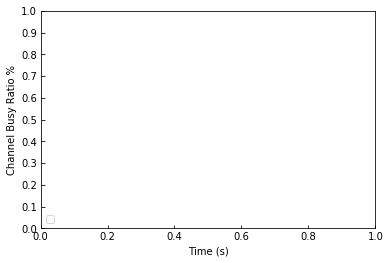

In [22]:
plot_cbr(motivational_cbr, ["Highway Fast", "Medium Density", "High Density"], "motivationalCBR")

In [23]:
plot_cbr(cbr_medium, ["DCC Access", "No Congestion Control", "3GPP DCC Mechanism (CBR) - Immediate new grant", "3GPP DCC Mechanism (CBR) - 5 missed trans b4 new grant"], "medium-CBR")

NameError: name 'cbr_medium' is not defined

In [24]:
plot_cbr(cbr_high, ["DCC Access", "No Congestion Control", "3GPP DCC Mechanism (CBR) - Immediate new grant", "3GPP DCC Mechanism (CBR) - 5 missed trans b4 new grant"], "high-CBR")

NameError: name 'cbr_high' is not defined

## Collisions issue

Section includes code to generate the collision causes and what happens when a grant is generated.

In [25]:
raw_data_folder = "/Users/brianmccarthy/git_repos/results-analysis/data/raw_data/cv2x/DCC-Enabled"

In [26]:
def random_selection_grant(raw_data_folder):    
    files = os.listdir(raw_data_folder)
    count = 0
    file = ""
    while ".csv" not in file and count < len(files) * 10:
        file = random.choice(files)
        count += 1

    result_file = raw_data_folder + "/" + file
    print("Random result file selected: {} in {} selections".format(result_file, count))
    random_df = pd.read_csv(result_file)

    # Reduce to the time we want which is from 502 onwards.
    random_df = random_df[random_df["Time"] >= 502]

    node = np.random.choice(random_df["NodeID"].unique(), 1)[0]
    print("Node: {}".format(node))
    subsection_df = random_df[random_df["NodeID"] == node]
    grant_time = np.random.choice(subsection_df["grantStartTime"].unique(), 1)[0]
    selectedSubchannel = subsection_df[subsection_df["grantStartTime"] == grant_time]["selectedSubchannelIndex"]
    selectedSubchannel = selectedSubchannel.get_values()[0]
    print("Grant Time: {}, subchannel: {}".format(grant_time, selectedSubchannel))
    generated_time = subsection_df[subsection_df["grantStartTime"] == grant_time]["Time"]
    generated_time = generated_time.get_values()[0]
    print("Time of generation: {}".format(generated_time))
    history_time = generated_time - 0.1
    print("Minimum history time: {}".format(history_time))
    future_time = generated_time + 0.1
    print("Maximum Future grant time: {}".format(future_time))
    
    return random_df, node, generated_time, grant_time, selectedSubchannel, history_time, future_time

In [27]:
df, node, generated_time, grant_time, subchannel, history_time, future_time = random_selection_grant(raw_data_folder)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/brianmccarthy/git_repos/results-analysis/data/raw_data/cv2x/DCC-Enabled'

In [28]:
df["grantBreakMissedTrans"].count()

NameError: name 'df' is not defined

In [29]:
df["grantBreak"].count()

NameError: name 'df' is not defined

In [30]:
df["grantBreakSize"].count()

NameError: name 'df' is not defined

In [31]:
df["grantStartTime"].count()

NameError: name 'df' is not defined

In [32]:
subframeIndex = int((grant_time - generated_time)* 1000)

NameError: name 'grant_time' is not defined

In [33]:
df = df[(df["Time"] >= history_time) & (df["Time"] <= future_time)]

NameError: name 'df' is not defined

In [34]:
df_removed = df.drop(["generatedGrants", "grantBreak", "tbSent", "tbFailedDueToProp", "tbFailedDueToInterference", "missedTransmission", "grantStartTime", "grantBreakSize", "grantBreakMissedTrans", "sciFailedDueToInterference", "sciFailedDueToProp", "subchannelSent", "subchannelsUsedToSend", "selectedSubchannelIndex", "selectedNumSubchannels", "subchannelsUsed", "sciSent"], axis=1)

NameError: name 'df' is not defined

In [35]:
df_removed = df_removed[df_removed["sciDecoded"].notnull()]

NameError: name 'df_removed' is not defined

In [36]:
for column in ["tbDecoded", "tbFailedButSCIReceived", "tbFailedDueToNoSCI", "tbFailedHalfDuplex", "tbReceived", "txRxDistanceTB"]:
    df_removed[column].fillna(-1, inplace=True)

NameError: name 'df_removed' is not defined

In [37]:
tb_df = df_removed.drop(["cbr", "interPacketDelay", "posX", "posY", "senderID","sciDecoded","sciFailedHalfDuplex","sciNotDecoded","sciReceived","subchannelReceived","txRxDistanceSCI"], axis=1)
sci_df = df_removed.drop(["tbDecoded","tbFailedButSCIReceived","tbFailedDueToNoSCI","tbFailedHalfDuplex","tbReceived","txRxDistanceTB"], axis=1)

scis_with_tb = sci_df[sci_df["txRxDistanceSCI"].isin(tb_df["txRxDistanceTB"].unique())]
tbs_there = tb_df[tb_df["tbDecoded"] != -1]

scis_without_tb = sci_df[~sci_df["txRxDistanceSCI"].isin(tb_df["txRxDistanceTB"].unique())]
tbs_missing = tb_df[tb_df["tbDecoded"] == -1]

scis_with_tb = scis_with_tb.merge(tbs_there, left_on=["NodeID", "Time", "txRxDistanceSCI"], right_on=["NodeID", "Time", "txRxDistanceTB"])

scis_without_tb_merge = scis_without_tb.merge(tbs_missing, how="right", left_on=["NodeID", "Time"], right_on=["NodeID", "Time"])
scis_without_tb_merge = scis_without_tb_merge.drop_duplicates(subset="txRxDistanceSCI")

df_removed = scis_without_tb_merge.append(scis_with_tb, sort=False)

NameError: name 'df_removed' is not defined

In [38]:
subchannels = 3
before_grant = []
after_grant = []
for i in range(subchannels):
    before_grant.append([])
    after_grant.append([])
    
before_grant_df = df_removed[df_removed["Time"] <= generated_time]
after_grant_df = df_removed[df_removed["Time"] >= generated_time]

# 0 = F
# 1 = T
time = round(history_time, 3)
index = 0
while time < generated_time:
    # Fill in this subframe
    for channel in before_grant:
        channel.append(0)
    filtered_df = before_grant_df[(before_grant_df["Time"] == time) & (before_grant_df["NodeID"] == node) & (before_grant_df["sciDecoded"] == 1)]
    if not filtered_df.empty:
        subchs = filtered_df["subchannelReceived"].values
        tbDecods = filtered_df["tbDecoded"].values
        for i in range(len(tbDecods)):
            if tbDecods[i] == 1:
                before_grant[int(subchs[i])][index] = 1
            elif tbDecods[i] == -1:
                before_grant[int(subchs[i][index])] = 2
    time = round(time + 0.001, 3)
    index += 1

# 0 = F -> F
# 1 = T -> F
# 2 = F -> T
# 3 = T -> T
# 4 = F -> M
# 5 = T -> M
# 6 = Selected
time = round(generated_time, 3)
index = 0
while time < future_time:
    # Fill in this subframe
    for i in range(len(after_grant)):
        if before_grant[i][index] == 0:
            after_grant[i].append(0)
        else:
            after_grant[i].append(1)
    filtered_df = after_grant_df[(after_grant_df["Time"] == time) & (after_grant_df["NodeID"] == node)]
    if not filtered_df.empty:
        subchs = filtered_df["subchannelReceived"].values
        tbDecods = filtered_df["tbDecoded"].values
        for i in range(len(tbDecods)):
            if tbDecods[i] == 1 and before_grant[int(subchs[i])][index] == 0:
                after_grant[int(subchs[i])][index] = 2
            elif tbDecods[i] == 1 and before_grant[int(subchs[i])][index] == 1:
                after_grant[int(subchs[i])][index] = 3
            elif tbDecods[i] == 1 and before_grant[int(subchs[i])][index] == 2:
                after_grant[int(subchs[i])][index] = 4
            elif tbDecods[i] == -1 and before_grant[int(subchs[i])][index] == 0:
                after_grant[int(subchs[i])][index] = 5
            elif tbDecods[i] == -1 and before_grant[int(subchs[i])][index] == 1:
                after_grant[int(subchs[i])][index] = 6
            elif tbDecods[i] == -1 and before_grant[int(subchs[i])][index] == 2:
                after_grant[int(subchs[i])][index] = 7
                
    if index == subframeIndex:
        after_grant[int(subchannel)][index] = 6
    time = round(time + 0.001, 3)
    index += 1

NameError: name 'df_removed' is not defined

In [39]:
after_grant_df[after_grant_df["NodeID"] == 220]["tbDecoded"].unique()

NameError: name 'after_grant_df' is not defined

In [40]:
print(len(before_grant), len(before_grant[0]))
print(len(after_grant), len(after_grant[0]))

3 0
3 0


In [41]:
fig, ax = plt.subplots(figsize=(30, 3))
im = ax.imshow(before_grant, interpolation="nearest", cmap=plt.cm.Paired_r)

# We want to show all ticks...
ax.set_xticks(np.arange(len(before_grant[0]), step=20))
ax.set_yticks(np.arange(len(before_grant)))

# ax.set_xticklabels(np_xticks)
# ax.set_xticklabels(np.array(before_grant)[subframes])

for i in range(len(before_grant)):
    for j in range(len(before_grant[i])):
        if before_grant[i][j] == 1:
            text = ax.text(j, i, "T", ha="center", va="center", color="Black")
        elif before_grant[i][j] == -1:
            text = ax.text(j, i, "M", ha="center", va="center", color="Black")
        else:
            text = ax.text(j, i, "F", ha="center", va="center", color="Black")

plt.gcf().set_facecolor("black")
plt.savefig("{}/{}.png".format(figure_folder, "test_history"), dpi=300)

/Users/brianmccarthy/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  


In [42]:
# 0 =  F -> F  = F
# 1 =  T -> F  = R
# 2 =  M -> T  = MT
# 3 =  F -> T  = N
# 4 =  T -> T  = T
# 5 =  F -> M  = NM
# 6 =  T -> M  = M
# 7 =  M -> M  = MM
# 8 = Selected = S

fig, ax = plt.subplots(figsize=(30, 3))
im = ax.imshow(after_grant, interpolation="nearest", cmap=plt.cm.Paired_r)

# We want to show all ticks...
ax.set_xticks(np.arange(len(after_grant[0]), step=20))
ax.set_yticks(np.arange(len(after_grant)))

for i in range(len(after_grant)):
    for j in range(len(after_grant[i])):
        if after_grant[i][j] == 0:
            text = ax.text(j, i, "F", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 1:
            text= ax.text(j, i, "R", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 2:
            text= ax.text(j, i, "MT", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 3:
            text= ax.text(j, i, "N", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 4:
            text= ax.text(j, i, "N", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 5:
            text= ax.text(j, i, "T", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 6:
            text= ax.text(j, i, "NM", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 7:
            text= ax.text(j, i, "M", ha="center", va="center", color="Black")
        elif after_grant[i][j] == 8:
            text= ax.text(j, i, "MM", ha="center", va="center", color="Black")
        else:
            text = ax.text(j, i, "F", ha="center", va="center", color="Black")

plt.gcf().set_facecolor("black")
plt.savefig("{}/{}.png".format(figure_folder, "test_future"), dpi=300)

/Users/brianmccarthy/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  if sys.path[0] == '':


## Setup

In [43]:
p = .95

In [44]:
csv_path = "/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/"
results = [
    "No Congestion Control",
    "CR-limit",
    "DCC"
]

less_interesting_results = [
    "High-Density",
    "Low-Density",
    "Random-Access"
]

### Getting the information out

In [45]:
def combine_line(line):
    mean_a = line["sum_x"]
    count_a = line["count_x"]

    mean_b = line["sum_y"]
    count_b = line["count_y"]

    if np.isnan(mean_a) and np.isnan(mean_b):
        return [mean_a, count_a]
    elif np.isnan(mean_a) and not np.isnan(mean_b):
        return [mean_b, count_b]
    elif np.isnan(mean_b) and not np.isnan(mean_a):
        return [mean_a, count_a]
    else:
        ex_a = mean_a * count_a
        ex_b = mean_b * count_b

        tx = ex_a + ex_b
        tn = count_a + count_b

        overall_mean = tx / tn
        overall_count = tn

        return [overall_mean, overall_count]

In [46]:
def combine_runs(line, mean_cols, t_value):
    means = []
    for mean in mean_cols:
        means.append(line[mean])

    n = len(means)

    # Average Across runs
    xBar = sum(means) / n

    # Deviation between runs and average
    deviation = []
    for mean in means:
        deviation.append((mean - xBar) ** 2)
    s2 = sum(deviation) / (n - 1)

    # Confidence interval
    ci = t_value * math.sqrt(s2 / n)

    return [xBar, ci]

In [47]:
def stat_distance( agg_df, df, stat, distance, percentage):

    # Reduce the size of the DF to what we're interested in.
    distance_df = df[df[stat].notnull()]
    distance_df = distance_df[["Time", "NodeID", stat, distance, "posX"]]
    distance_df = distance_df[distance_df[stat] > -1]
    # distance_df = distance_df[(distance_df["posX"] > 1500) & (distance_df["posX"] < 3500)]

    # Only interested in max 500m simply as it's not all that relevant to go further.
    # Note that going to the max distance of the file can cause issues with how they are parsed.
    max_distance = min(510, distance_df[distance].max())

    # Get the mean, std, count for each distance
    distance_df = distance_df.groupby(
        pd.cut(distance_df[distance], np.arange(0, max_distance, 25))).agg(
        {stat: ["sum", "count"]})

    # Remove over head column
    distance_df.columns = distance_df.columns.droplevel()

    if percentage:
        distance_df = distance_df.apply(lambda x: x * 100, axis=1)

    if agg_df.empty:
        agg_df = distance_df
    else:
        # combine_chunks
        agg_df = pd.merge(agg_df, distance_df, on=distance, how='outer')
        agg_df = agg_df.apply(combine_line, axis=1, result_type='expand')
        agg_df = agg_df.rename({0: "sum", 1: "count"}, axis='columns')

    return agg_df

In [53]:
overall_info = {}
for result_folder in results:
    overall_info[result_folder] = {}
    
    tb_info = pd.DataFrame()
    file_count = 0
    grant_info = pd.DataFrame()
    
    try:
        print("****  {:}  ****".format(result_folder))
        for file_name in os.listdir(os.path.join(csv_path, result_folder)):
            file_path = os.path.join(csv_path, result_folder, file_name)
            
            agg_df = pd.DataFrame()
            grant_df = pd.DataFrame()
            file_count += 1
            for chunk in pd.read_csv(file_path, chunksize=10 ** 6):
                agg_df = stat_distance(agg_df, chunk, "tbDecoded", "txRxDistanceTB", percentage=False)
                
                row = []
                row.append(chunk["grantBreakMissedTrans"].count())
                
                grant_df = pd.DataFrame([row], columns=["BreakMissedTrans"])
                
            if tb_info.empty:
                tb_info = agg_df
            else:
                tb_info = pd.merge(tb_info, agg_df, how='outer', on="txRxDistanceTB",
                                   suffixes=(file_count, file_count + 1),
                                   copy=True, indicator=False)
                
            if grant_info.empty:
                grant_info = grant_df
            else:
                grant_info = pd.merge(grant_info, grant_df, how="outer", suffixes=(file_count, file_count +1),
                                      copy=True, indicator=False)
    
        mean_cols = tb_info.filter(regex='sum').columns

        n = len(mean_cols) - 1
        t_value = t.ppf(p, n)

        tb_info = tb_info.apply(combine_runs, axis=1, result_type='expand', args=(mean_cols, t_value,))
        tb_info = tb_info.rename({0: "sum", 1: "Confidence-Interval"}, axis='columns')
        
        mean_cols = grant_info.filter(regex='BreakMissedTrans').columns

        n = len(mean_cols) - 1
        t_value = t.ppf(p, n)
        
        grant_info = grant_info.apply(combine_runs, axis=1, result_type='expand', args=(mean_cols, t_value,))
        grant_info = grant_info.rename({0: "grantBreaks", 1: "Confidence-Interval"}, axis='columns')

        overall_info[result_folder]["tb_info"] = tb_info
        overall_info[result_folder]["missed_trans"] = grant_info
        
    except FileNotFoundError:
        print("{} does not contain processed results".format(result_folder))

****  No Congestion Control  ****


/Users/brianmccarthy/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


****  CR-limit  ****


/Users/brianmccarthy/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


****  DCC  ****


/Users/brianmccarthy/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


### Absolute Arrival rates

In [49]:
def dist_graph(means, distances, labels, plot_name, ylabel, now, figure_store, legend_pos="lower left",
               confidence_intervals=None, show=True, store=False, percentage=False):
    fig, ax = plt.subplots()

    for i in range(len(means)):
        if confidence_intervals:
            ax.errorbar(distances, means[i], yerr=confidence_intervals[i], label=labels[i])
        else:
            ax.plot(distances, means[i], label=labels[i])

    ax.set(xlabel='Distance (m)', ylabel=ylabel)
    ax.legend(loc=legend_pos)
    ax.tick_params(direction='in')

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    if percentage:
        ax.set_ylim([0, 100])
        plt.yticks(np.arange(0, 101, step=10))

    if show:
        fig.show()

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [50]:
figure_store = "../data/figures/"
confidence_intervals = False
distances = np.arange(0, 500, 25)

In [54]:
# # DCC + NO-CC
# labels = ["DCC", "NO-CC"]
# means = []
# cis = []
# for key in ["DCC", "No-Congestion-Control"]:
#     means.append(list(overall_info[key]["tb_info"]["sum"]))

#     cis.append(list(overall_info[key]["tb_info"]["Confidence-Interval"]))
        
# dist_graph(means, distances, labels, "DCC-AA", "Absolute Arrivals", "now", figure_store, store=True)

labels = ["No Congestion Control", "CR-Limit", "DCC"]
means = []
cis = []
for key in ["No Congestion Control", "CR-limit", "DCC"]:
    means.append(list(overall_info[key]["tb_info"]["sum"]))

    cis.append(list(overall_info[key]["tb_info"]["Confidence-Interval"]))
        
dist_graph(means, distances, labels, "RRI-Adaptation-long-Absolute-Arrivals", "Absolute Arrivals", "now", figure_store, store=True)

# labels = ["No Congestion Control", "Packet Dropping no grant break", "Packet Dropping Immediate Grant Break"]
# means = []
# cis = []
# for key in ["No-Congestion-Control", "Packet-Dropping-Grant-Break-After-5-Missed-Trans", "Packet-Dropping-Immediate-Grant-Break"]:
#     means.append(list(overall_info[key]["tb_info"]["sum"]))

#     cis.append(list(overall_info[key]["tb_info"]["Confidence-Interval"]))
        
# dist_graph(means, distances, labels, "PacketDropping-AA", "Absolute Arrivals", "now", figure_store, store=True)

# labels = ["No Congestion Control", "CR-Limit", "DCC"]
# means = []
# cis = []
# for key in ["No-Congestion-Control", "RRI-Adaptation-CR-limit", "RRI-Adaptation-DCC-full"]:
#     means.append(list(overall_info[key]["tb_info"]["sum"]))

#     cis.append(list(overall_info[key]["tb_info"]["Confidence-Interval"]))
        
# dist_graph(means, distances, labels, "RRI-Adaptation-AA", "Absolute Arrivals", "now", figure_store, store=True)

/Users/brianmccarthy/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


### Misleading grants

In [55]:
labels = ["No Congestion Control", "CR-Limit", "DCC"]
means = []
cis = []
for key in ["No Congestion Control", "CR-limit", "DCC"]:
    means.append(list(overall_info[key]["missed_trans"]["grantBreaks"]))
    
fig, ax = plt.subplots()
ax.set_ylabel('Unused Resources')
ax.boxplot(means, labels=labels)

fig.savefig("{}/{}.png".format(figure_store, "RRI-Adaptation-long-grantBreaks"), dpi=300)

plt.close(fig)

In [34]:
# DCC + NO-CC
labels = ["DCC", "NO-CC"]
means = []
cis = []
for key in ["DCC", "No-Congestion-Control"]:
    means.append(list(overall_info[key]["missed_trans"]["grantBreaks"]))
    
fig, ax = plt.subplots()
ax.set_ylabel('Unused Resources')
ax.boxplot(means, labels=labels)
fig.savefig("{}/{}.png".format(figure_store, "DCC-box-plot"), dpi=300)

plt.close(fig)

KeyError: 'No-Congestion-Control'

In [226]:
labels = ["No Congestion Control", "No grant break", "Immediate Grant Break"]
means = []
cis = []
for key in ["No-Congestion-Control", "Packet-Dropping-Grant-Break-After-5-Missed-Trans", "Packet-Dropping-Immediate-Grant-Break"]:
    means.append(list(overall_info[key]["missed_trans"]["grantBreaks"]))
    
fig, ax = plt.subplots()
ax.set_ylabel('Unused Resources')
ax.boxplot(means, labels=labels)  

fig.savefig("{}/{}.png".format(figure_store, "Packet-Drop-boxplot"), dpi=300)

plt.close(fig)

In [227]:
labels = ["No Congestion Control", "CR-Limit", "DCC"]
means = []
cis = []
for key in ["No-Congestion-Control", "RRI-Adaptation-CR-limit", "RRI-Adaptation-DCC-full"]:
    means.append(list(overall_info[key]["missed_trans"]["grantBreaks"]))
    
fig, ax = plt.subplots()
ax.set_ylabel('Unused Resources')
ax.boxplot(means, labels=labels)

fig.savefig("{}/{}.png".format(figure_store, "Long-RRI-box-plot"), dpi=300)

plt.close(fig)